# **Pneumonia Detection from Chest X-Rays**

## **Overview**

We're going to be making a classifier that takes in images of AP Chest X-rays and outputs whether the patient has pneumonia or not. We will also visualize what parts of the image were most important to making a decision using Gradcam.

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"manojkumarkarumanchi","key":"5a746fc35fc9960da43b5179577deac6"}'}

In [4]:
!pip install kaggle
!mkdir /root/.kaggle
!cp kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip
!rm -rf chest_xray/__MACOSX
!rm -rf chest_xray/chest_xray

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0449-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0450-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0451

**Load datasets into memory & Visualize Distributions bold text**

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from imutils import paths
from sklearn.model_selection import train_test_split

def generate_dataframe(directory):
  img_paths = list(paths.list_images(directory))
  labels = ['normal' if x.find('NORMAL') > -1 else 'pn' for x in img_paths]
  return pd.DataFrame({ 'paths': img_paths, 'labels': labels })

all_df = generate_dataframe('chest_xray')

train, test = train_test_split(all_df, test_size=0.2, random_state=42)

print(train['labels'].value_counts())
print(test['labels'].value_counts())

pn        3436
normal    1248
Name: labels, dtype: int64
pn        837
normal    335
Name: labels, dtype: int64


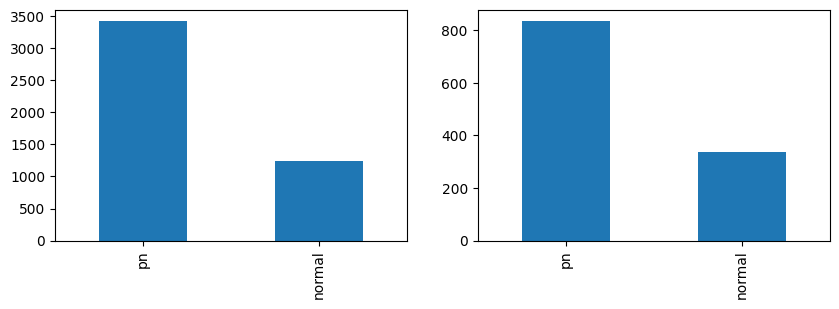

In [17]:
fig = plt.figure(figsize=(10,3))
for idx, x in enumerate([train, test]):
  fig.add_subplot(1,2,idx+1)
  x['labels'].value_counts().plot(kind='bar')


**Make Image Generators + Visualize Augmentations**

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_generators(train, test, size=224, b=64):
  train_generator = ImageDataGenerator(
      rescale=1./255, rotation_range=5, width_shift_range=0.1,
      height_shift_range=0.1, validation_split=0.2
  )
  test_generator = ImageDataGenerator(rescale=1./255)
  
  baseargs = {
      "x_col": 'paths', 
      "y_col": 'labels',
      "class_labels": ['normal', 'pn'], 
      "class_mode": 'binary',
      "target_size": (size,size), 
      "batch_size": b, 
      "seed": 42
  }
  train_generator_flow = train_generator.flow_from_dataframe(
    **baseargs, 
    dataframe=train, 
    subset='training')
  validation_generator_flow = train_generator.flow_from_dataframe(
    **baseargs, 
    dataframe=train, 
    subset='validation')
  test_generator_flow = test_generator.flow_from_dataframe(
      dataframe=test,
      shuffle=False, 
      **baseargs)
  
  return train_generator_flow, validation_generator_flow, test_generator_flow

Found 3748 validated image filenames belonging to 2 classes.
Found 936 validated image filenames belonging to 2 classes.
Found 1172 validated image filenames belonging to 2 classes.


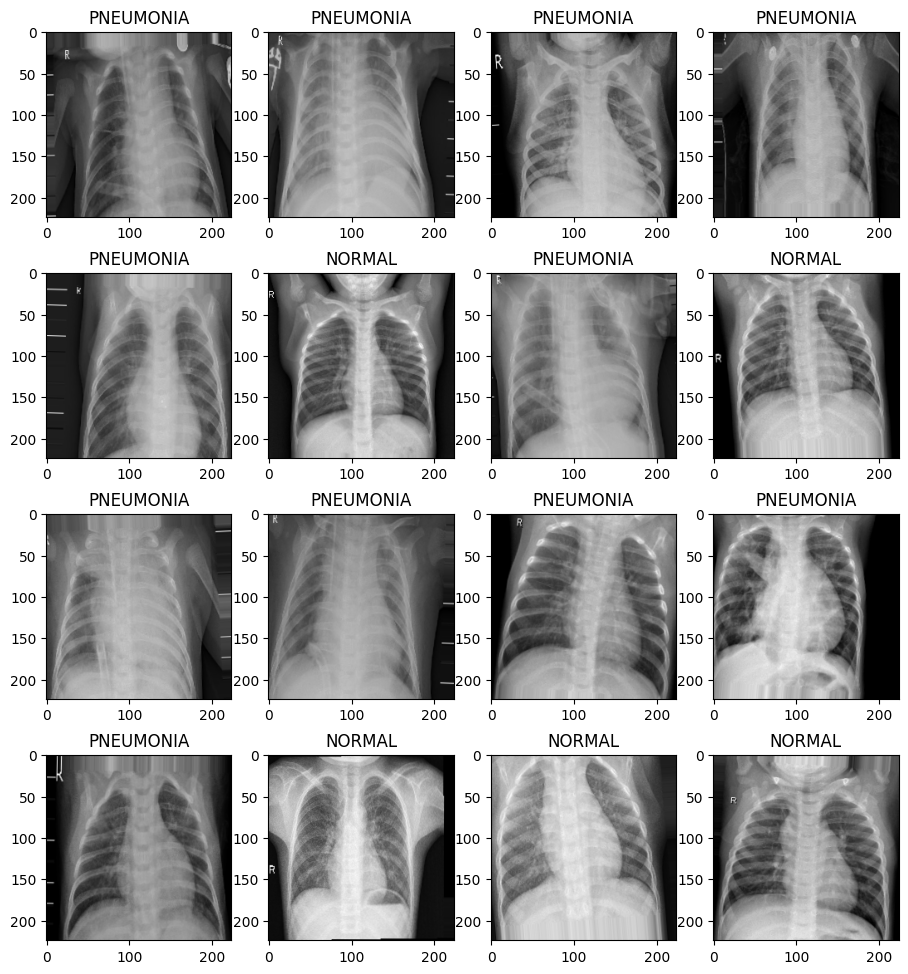

In [19]:
train_generator, validation_generator, test_generator = create_generators(train, test, 224, 32)

imgs = train_generator.next()
fig = plt.figure(figsize=(11,12))
for i in range(16):
  fig.add_subplot(4,4,i+1)
  image = imgs[0][i]
  label = 'PNEUMONIA' if imgs[1][i] == 1 else 'NORMAL'
  plt.imshow(image)
  plt.title(label)

Define Networks (SmallNet and VGG16)

In [20]:
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model

from datetime import datetime

In [21]:
def make_smallnet():
  SIZE = 224
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation="relu"))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation="relu"))

  model.add(Flatten())
  model.add(Dense(64, activation="relu"))
  model.add(Dense(1, activation="sigmoid"))

  model.compile(optimizer='adam',
                loss='binary_crossentropy', 
                metrics=['accuracy', Recall(name='recall'), 
                        Precision(name='precision'), AUC(name='auc')])

  return model

In [22]:
def make_VGGnet():
  SIZE = 224
  m = VGG16(weights = 'imagenet', 
                include_top = False, 
                input_shape = (SIZE, SIZE, 3))
  for layer in m.layers:
    layer.trainable = False

  x = Flatten()(m.output)
  x = Dense(4096, activation="relu")(x)
  x = Dense(1072, activation="relu")(x)
  x = Dropout(0.2)(x)
  predictions = Dense(1, activation="sigmoid")(x)

  model = Model(inputs=m.input, outputs=predictions)
  ## Compile and run
  
  adam = Adam(learning_rate=0.001)
  model.compile(optimizer=adam,
                loss='binary_crossentropy', 
                metrics=['accuracy', Recall(name='recall'), 
                        Precision(name='precision'), AUC(name='auc')])
  return model

In [23]:
def get_callbacks(model_name):
  # Callbacks
  ## Keep the best model
  logdir = (
      f'logs/scalars/{model_name}_{datetime.now().strftime("%m%d%Y-%H%M%S")}'
  )
  tb = TensorBoard(log_dir=logdir)
  es = EarlyStopping(
        monitor="val_loss",
        min_delta=1,  # model should improve by at least 1%
        patience=20,  # amount of epochs  with improvements worse than 1% until the model stops
        verbose=2,
        mode="min",
        restore_best_weights=True,  # restore the best model with the lowest validation error
    )
  mc = ModelCheckpoint(f'model_{model_name}.hdf5', 
                      save_best_only=True, 
                      monitor='val_loss', 
                      mode='min')

  ## Reduce learning rate if it gets stuck in a plateau
  rlr = ReduceLROnPlateau(monitor='val_loss', 
                          factor=0.3, 
                          patience=3, 
                          min_lr=0.000001, 
                          verbose=1)
  return [tb, es, mc, rlr]

In [24]:
def fit_model(train_generator, validation_generator, model_name, batch_size=32, epochs=15, model_fname=None):
  if model_fname == None:
    if model_name == 'smallnet':
      model = make_smallnet()
    if model_name == 'vgg':
      model = make_VGGnet()
    model.summary()
    plot_model(model, to_file=model_name + '.jpg', show_shapes=True)
  else:
    model = load_model(model_fname)
  
  model_history = model.fit(train_generator,
                            validation_data=validation_generator,
                            steps_per_epoch=train_generator.n/batch_size,
                            validation_steps=validation_generator.n/batch_size,
                            epochs=epochs,
                            verbose=1,
                            callbacks=get_callbacks(model_name))
  return model, model_history

In [26]:
small_model, small_model_hist = fit_model(train_generator, validation_generator, 'smallnet', epochs=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 173056)           

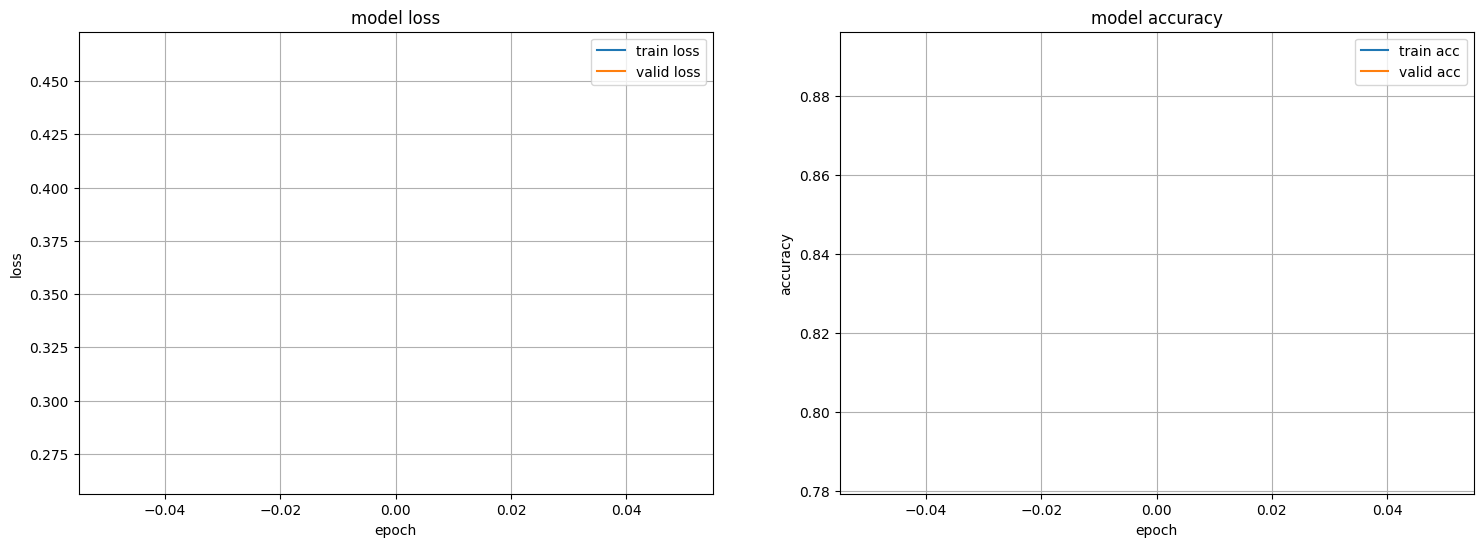

In [29]:
def plot_history(history):
    
    fig = plt.figure(figsize = (18 , 6))

    fig.add_subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train loss', 'valid loss'])
    plt.grid(True)
    plt.plot()
    
    fig.add_subplot(1,2,2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train acc', 'valid acc'])
    plt.grid(True)
    plt.plot()

plot_history(small_model_hist)

# **Visualize model attention with GradCAM**

In [32]:
!git clone https://github.com/gkeechin/vizgradcam.git
!cp vizgradcam/gradcam.py gradcam.py

Cloning into 'vizgradcam'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 67 (delta 32), reused 24 (delta 6), pack-reused 0
Unpacking objects: 100% (67/67), 1.08 MiB | 1.22 MiB/s, done.


In [33]:
from gradcam import VizGradCAM

def display_map_and_conf(model, test_generator):
  imgs = test_generator.next()
  fig = plt.figure(figsize=(15,5))

  for i in range(3):
    fig.add_subplot(1,3,i+1)
    image = imgs[0][i]
    label = 'PNEUMONIA' if imgs[1][i] == 1 else 'NORMAL'
    VizGradCAM(model, image, plot_results=True, interpolant=0.5)
    out_prob = model.predict(image.reshape(1,224,224,3))[0][0]
    title = f"Prediction: {'PNEUMONIA' if out_prob > 0.5 else 'NORMAL'}\n"
    title += f"Prob(Pneumonia): {out_prob}\n"
    title += f"True Label: {label}\n"
    plt.title(title)

1/1 [==============================] - 0s 49ms/step


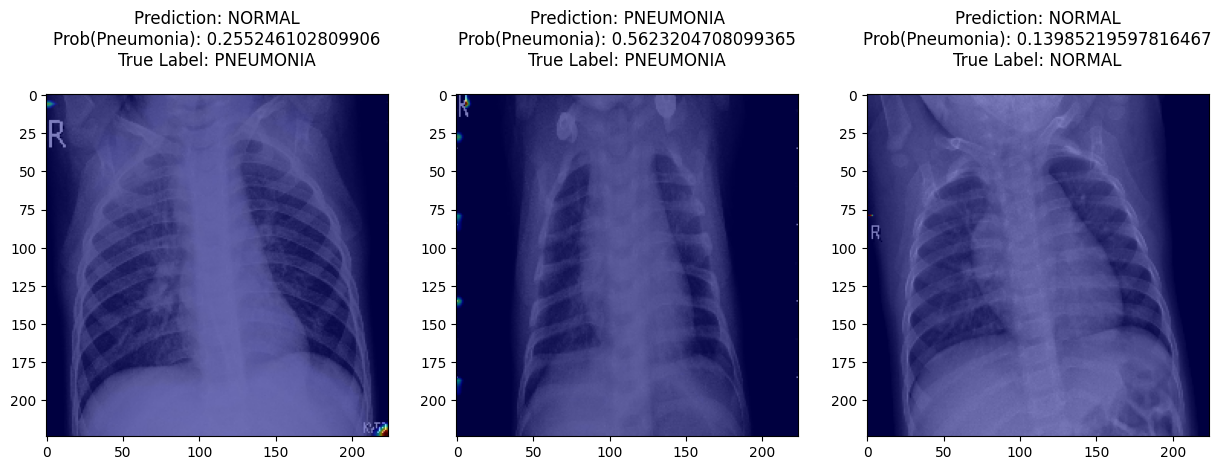

In [35]:
display_map_and_conf(small_model, test_generator)

In [36]:
from sklearn.metrics import (roc_curve, auc, classification_report,
RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay)

def get_stats(model, generator, model_name):
  preds = model.predict(generator)
  pred_classes = [1 if x >= 0.5 else 0 for x in preds]
  true_vals = generator.classes
  print("CLASSIFICATION REPORT")
  print(classification_report(true_vals, pred_classes, target_names=['normal','pn']))
  cm = confusion_matrix(true_vals, pred_classes)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal','pn'])
  disp.plot(values_format='')
  fpr, tpr, thresholds = roc_curve(true_vals, preds)
  auc_val = auc(fpr, tpr)
  print("AUC is ", auc_val)
  display = RocCurveDisplay(fpr, tpr, auc_val, model_name)
  display.plot()
  plt.show()

In [38]:
small_model_ld = load_model('model_smallnet.hdf5')

37/37 [==============================] - 54s 1s/step
CLASSIFICATION REPORT
              precision    recall  f1-score   support

      normal       0.75      0.94      0.84       335
          pn       0.97      0.88      0.92       837

    accuracy                           0.90      1172
   macro avg       0.86      0.91      0.88      1172
weighted avg       0.91      0.90      0.90      1172

AUC is  0.9648923839583443


TypeError: ignored

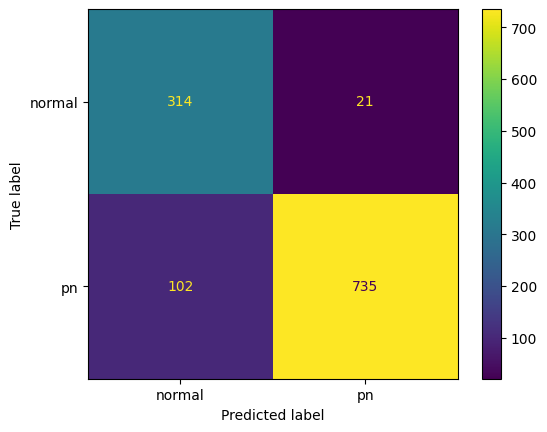

In [39]:
get_stats(small_model, test_generator, "smallnet")

# Evaluation of any Image

In [41]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import numpy as np

def predict_image(model, img_path):
  img = img_to_array(load_img(img_path, target_size=(224,224,3)))
  img = img * (1./255)
  img = np.expand_dims(img, axis=0)
  pred = model.predict(img)
  label = 'PNEUMONIA' if pred >= 0.5 else 'NORMAL'
  print("prediction: ", label, "P(Pneumonia): ", pred[0][0])

In [44]:
m = load_model('model_smallnet.hdf5')
predict_image(m, 'chest_xray/train/NORMAL/IM-0410-0001.jpeg')

1/1 [==============================] - 0s 306ms/step
prediction:  NORMAL P(Pneumonia):  0.027182145
